Steven Black

Due 10-25-2020

IS 678 Data Analytics in Cybersecurity (01.13496/02.13497) FA2020


# Make up Assignment I
## Prompt

Step 1:

Use the 20% subset of the KDDTrain+.txt file from NSL-KDD Dataset located at https://www.unb.ca/cic/datasets/nsl.html for this exercise. Read the information in the URL to guide you in understanding the dataset, then scroll to the end of the page for the 'download this dataset' link.

Step 2:

The next page will get you to fill a form; your organization is UMBC and your job title is student. Download the NSL-KDD zip file, unzip, and locate KDDTrain+_20Percent.TXT (you can change the extension to .csv)

Step 3

Create 2 training sets by selecting samples from this data set and evaluate them using decision trees (such as J48 in Weka). You can use random sampling or any other selective sampling technique. Compare the decision trees you find and describe any key changes between the trees.

Comment on why these changes may be occuring by looking at the class distribution in your samples or the size of your training samples.

You may use alternate analysis techniques such as clustering and associations to supplement your analysis (although this is not required).

Submit a word document of your assignment, please make sure to include the decision tree snapshots and other relevant snapshots in your assignment. You do not need to include snapshots of every intermediate step or analysis.

You can use weka or any other alternative data mining tool for this assignment.

Note that this is not KDD Cup 99 dataset but all preprocessing steps of homework 1 are still relevant for this dataset. The sample solution remains a guide for this homework 


## Intro



## 0. Prerequisites

Before analysis can begin we need to download the files and load the data such that we can intelligbly use it. 

This process, below, is comprised of several steps:
1. Install python libraries
2. Load libraries and declare where the data will come from (the dataset, `KDDTrain+_20Percent.txt` was downloaded manually)
3. Download remaining files
4. View file contents with `head`
5. Load labels and data
6. Create DataFrame from labels and data


### 0.1 Install python libraries

Use the python package manager, PIP, to install machine-learning, data-manipulation, and graphing packages.


In [88]:
!pip install requests sklearn pandas numpy matplotlib seaborn > /dev/nul

### 0.2: Load libraries and declare vars

Load packages with the `import` keyworkd and declare where the data will come from. The dataset, `KDDTrain+_20Percent.txt`, was downloaded manually while the column names and label info is downloaded later. They can be retrieved from the UNB's site [1] or the original dataset on UCI's site [2].

In [118]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


kdd99_names_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names'
training_attack_types ='http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types'
kdd99_20p_filename = 'KDDTrain+_20Percent.csv'
kdd99_20p_url = "https://gist.githubusercontent.com/sblack4/3a34ebf5a8f02629f3f5ab8547c2f85f/raw/1985460fe1b036c28c0235871c6e770409be4e5b/KDDTrain+_20Percent.csv"

### 0.3 Download remaining files

Download the files containing the column names and a map of the attacks and their type. 

In [90]:
def dl_file(url):
  filename = os.path.basename(url)
  with open(filename, 'wb') as fh:
    r = requests.get(url)
    fh.write(r.content)
  return filename

files_to_dl = [kdd99_names_url, training_attack_types, kdd99_20p_url]

list(map(dl_file, files_to_dl))

['kddcup.names', 'training_attack_types', 'KDDTrain+_20Percent.csv']

### 0.4 View file contents

A quick looks at the first few lines for the three files. The data is raw and needs to be extracted. Without greater context it's pretty meaningless to us. The `head` command is used to quickly get these first few lines from through the shell. 

In [91]:
!head KDDTrain+_20Percent.txt

head: cannot open 'KDDTrain+_20Percent.txt' for reading: No such file or directory


In [92]:
!head kddcup.names

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.


In [93]:
!head training_attack_types

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos


### 0.5 Load labels and data

Here the files are read, parsed, and stored as variables so that we can manipulate them. The first file, `kddcup.names` has the colum names in it. In addition to the column names listed in the file the authors have added columns with the attack type and a number associated with successful predictions by one of several predicted labels [1]. 

These values are listed in Fig 1.


In [94]:
with open('kddcup.names', 'r') as fh:
  fh.readline() # get rid of the first line
  lines = fh.readlines()

col_names = []
for line in lines:
  name = line.split(':')[0]
  col_names.append(name)

# the last one is the target, attack_type
col_names.append('attack_type')
col_names.append('successfulPredictions')

### Fig 1. Column Names

In [95]:
for nm in col_names: print('  - ' + nm)

  - duration
  - protocol_type
  - service
  - flag
  - src_bytes
  - dst_bytes
  - land
  - wrong_fragment
  - urgent
  - hot
  - num_failed_logins
  - logged_in
  - num_compromised
  - root_shell
  - su_attempted
  - num_root
  - num_file_creations
  - num_shells
  - num_access_files
  - num_outbound_cmds
  - is_host_login
  - is_guest_login
  - count
  - srv_count
  - serror_rate
  - srv_serror_rate
  - rerror_rate
  - srv_rerror_rate
  - same_srv_rate
  - diff_srv_rate
  - srv_diff_host_rate
  - dst_host_count
  - dst_host_srv_count
  - dst_host_same_srv_rate
  - dst_host_diff_srv_rate
  - dst_host_same_src_port_rate
  - dst_host_srv_diff_host_rate
  - dst_host_serror_rate
  - dst_host_srv_serror_rate
  - dst_host_rerror_rate
  - dst_host_srv_rerror_rate
  - attack_type
  - successfulPredictions


The second file, `training_attack_types`, has a mapping between attack names and their more general attack type. This mapping reduces the 23 attacks to 4 types of attacks. This four-way classification of the dataset retains some information regarding the details of the attack. In the dataset there are not just records of attacks but also records of a normal state for our system. [2,3]

The mapping is printed in Fig 2 below.


In [96]:
with open('training_attack_types', 'r') as fh:
  lines = fh.readlines()

print('-'*24)
print(f'{"Attack ".rjust(16, " ")}-> type')
print('-'*24)
attack_types = {}
for line in lines:
  line = line.replace('\n', '')
  if not line: continue
  typ = line.split(' ')[0]
  cls = line.split(' ')[1]
  attack_types[typ] = cls

------------------------
         Attack -> type
------------------------


### Fig 2. Map of Attack Types

In [97]:
for typ, cls in attack_types.items(): print(f'{typ.ljust(16, " ")}-> {cls}')

back            -> dos
buffer_overflow -> u2r
ftp_write       -> r2l
guess_passwd    -> r2l
imap            -> r2l
ipsweep         -> probe
land            -> dos
loadmodule      -> u2r
multihop        -> r2l
neptune         -> dos
nmap            -> probe
perl            -> u2r
phf             -> r2l
pod             -> dos
portsweep       -> probe
rootkit         -> u2r
satan           -> probe
smurf           -> dos
spy             -> r2l
teardrop        -> dos
warezclient     -> r2l
warezmaster     -> r2l


### 0.6 Create DataFrame from labels and data

Finally we will load our data file, `KDDTrain+_20Percent.txt`. First, the pandas library is used to read it into a DataFrame with the column names we listed above. Then, the attack type (or similarly class) is appended as a column named `attack_type` and derived from the mapping above. Finally, we see the first five lines at the head of the DataFrame in Fig 3.

In [98]:
kdd99_20p_df = pd.read_csv(kdd99_20p_filename, names=col_names, index_col=None)

kdd99_20p_df['attack_class'] = kdd99_20p_df.apply(
    lambda x: 'normal' if x['attack_type'] == 'normal' else attack_types[x['attack_type']], 
    axis=1)

### Fig 3. First Five Rows

In [99]:
kdd99_20p_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,successfulPredictions,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


## 1. Data Statistics

The dataset is described using basic statistics in the next section. First we obtain the general shape of the dataset we are working with as given by rows and column in Fig 4. That is followed by the descriptive statistics for all the numerical columns in the dataset in Fig 5. This is followed by a refreshing chart showing some of the variation in our string variables, Fig 6. The categorical variables are investigated further with two charts showing the distributions for the attack type and the attack-class classification in Fig 7 & Fig 8. The largest class of our sample is `normal` and the attack type is the `neptune`, which dwarfs the other samples. Finally, the investigation concludes with a look into the covariance between numerical features in Fig 9. Highly correlated numerical features often are measuring the same underlying phenomena and so add no additional information but can confound predictors. Thus it behooves anyone aiming for an acccurate model to remove them.  


#### Fig 4. Dataset Shape (rows, cols)

In [100]:
kdd99_20p_df.shape

(25192, 44)

#### Fig 5. Descriptive Statistics of Numerical Columns

In [101]:
kdd99_20p_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,successfulPredictions
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769,19.487695
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333,2.328541
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


### Fig 6: Description of Categorical Variables

In [102]:
kdd99_20p_df.describe(include=['object'])

,protocol_type,service,flag,attack_type,attack_class
count,25192,25192,25192,25192,25192
unique,3,66,11,22,5
top,tcp,http,SF,normal,normal
freq,20526,8003,14973,13449,13449


### Fig 7. Bar Graph of Attack type

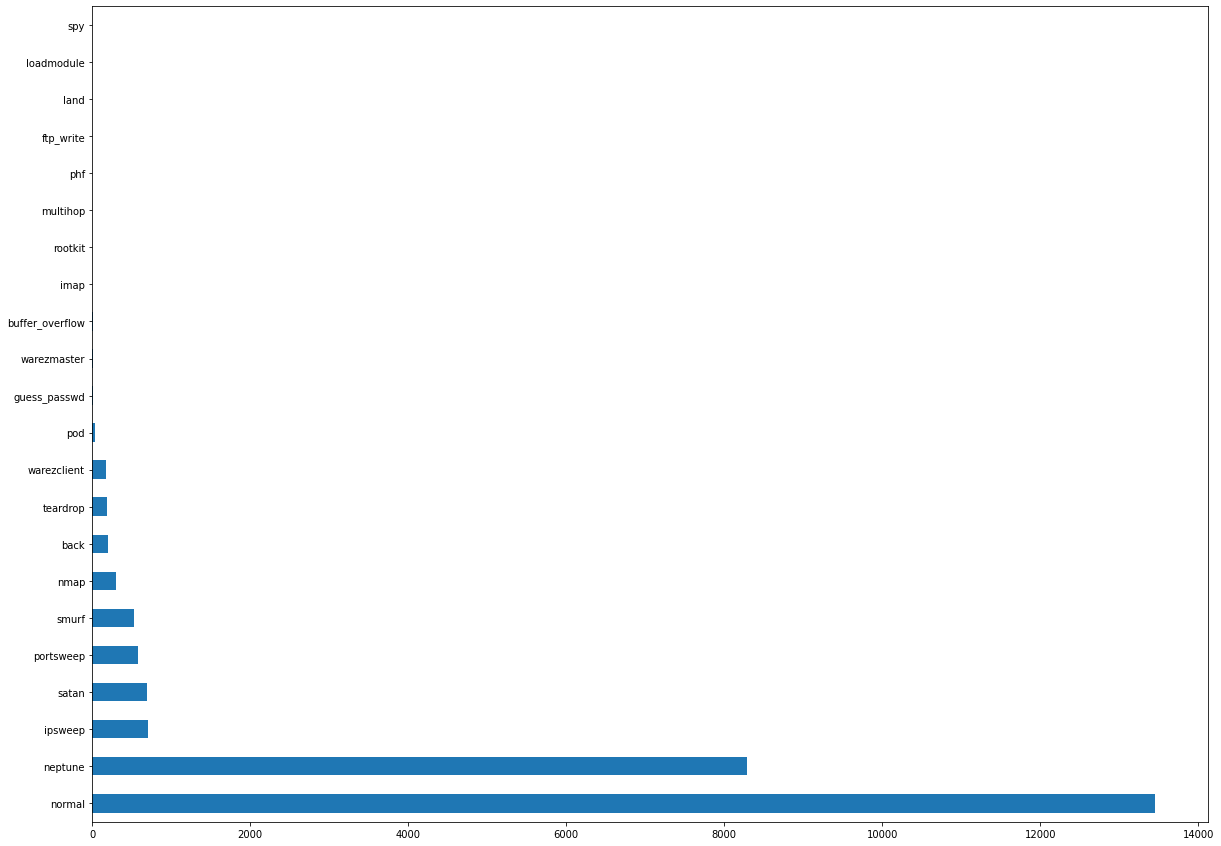

In [155]:
fig = plt.figure()
fig = kdd99_20p_df['attack_type'].value_counts().plot(figsize=(20, 15), kind="barh")
plt.show()

### Fig 8. Bar Graph of Attack Class

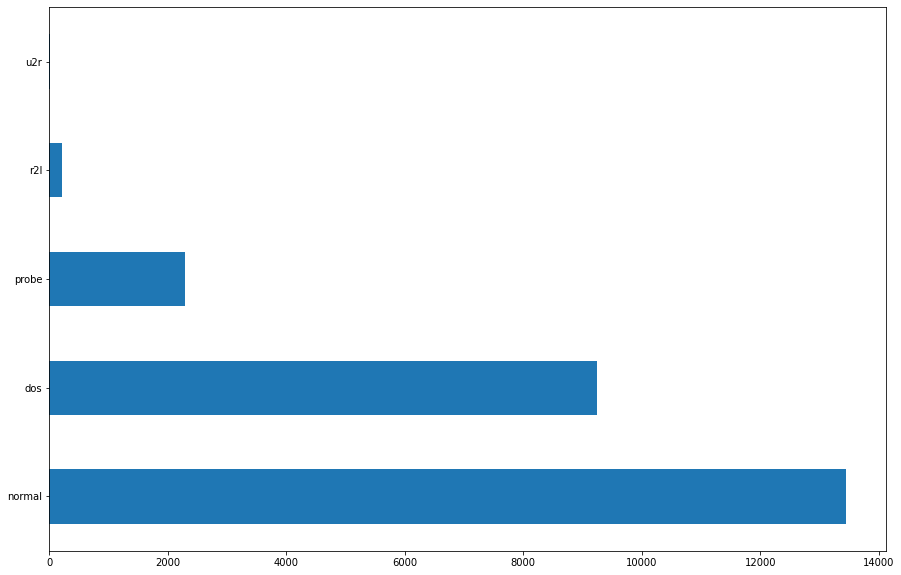

In [104]:
plt.figure(figsize=(15, 10))
kdd99_20p_df['attack_class'].value_counts().plot(kind="barh")
plt.show()

### Fig 9. Pairwise Correlation for floating point values

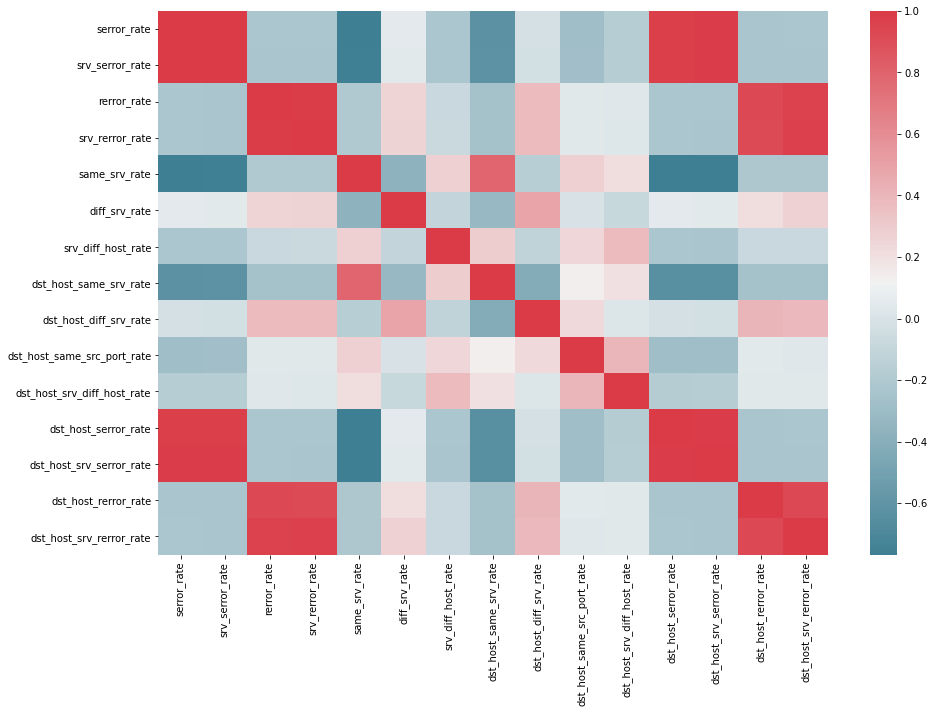

In [190]:
# pairwise correlation for float type values
corr = kdd99_20p_df.loc[:,kdd99_20p_df.dtypes == 'float64'].corr()

plt.figure(figsize = (15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

## 2. Engineering Data



### 2.1 Binary Classification of Dataset

The dataset was further classified into the binary types of attack or not attack (normal). This column was appended to our DataFrame. 


In [106]:
kdd99_20p_df['attack_biclass'] = kdd99_20p_df.apply(
    lambda x: 'normal' if x['attack_type'] == 'normal' else 'attack', 
    axis=1)

### 2.1 Remove Highly Correlated Features

Highly correlated features do not add information to datasets but they can confuse predictors and cause unstable decisions trees. In Fig 9 the correlations between variables are displayed as a heat map. The red intersections between `serror_rate`, `srv_serror_rate`, `dst_serror_rate`, `dst_srv_serror_rate` mean that they are largely all encoding for the same information. The column `serror_rate` was retained while `srv_serror_rate`, `dst_host_serror_rate`, and `dst_host_srv_serror_rate` were dropped.

The target variable used to assess our learner will be `attack_class`. The columns `attack_type`, `successfulPredictions`, and `attack_biclass` will be dropped. 


In [193]:
kdd99_20p_dropped = kdd99_20p_df.drop(['srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate'], axis=1)
kdd99_20p_dropped = kdd99_20p_dropped.drop(['attack_type', 'attack_biclass', 'successfulPredictions'], axis=1)

### 2.2 Transform Categorical Variables

The `DecisionTreeClassifier` needs values that can be coerced into an `ndarray`. This data set has `object`s in it which are just strings representing our categorical variables. These categorical variables could be encoded as numerics using a simple `OrdinalEncoder`. This is not considered the best way of transforming categorical variables because predictors can assume relationships between the values that are not present. It's considered best to transform the unique values into a series of binary columns denoting the presence of a particular value. For purposes of simplicity all categorical columns will be dropped [4].  



## 3. Data Sampling

Three samples were created that have different distributions for the data. Models are compared across samples. Each sample contains 400 elements.

- Random Sample
- Uniform Distribution
- Test Sample

In [194]:
n_sample = 400
random_sample = kdd99_20p_dropped.sample(n_sample)
uniform_sample = kdd99_20p_dropped.groupby('attack_class', group_keys=False)\
                                  .apply(lambda x: x.sample(int(n_sample/4), replace=True))
test_sample = kdd99_20p_dropped.sample(n_sample)

### Fig 10. Random Sample Attack Classes

In [228]:
random_sample.attack_class.value_counts()

normal    207
dos       161
probe      30
r2l         2
Name: attack_class, dtype: int64

### Fig 11. Uniform Sample Attack Classes

In [229]:
uniform_sample.attack_class.value_counts()

probe     100
r2l       100
dos       100
normal    100
u2r       100
Name: attack_class, dtype: int64

### Fig 12. Test Sample Attack Classes

In [230]:
test_sample.attack_class.value_counts()

normal    223
dos       151
probe      22
r2l         3
u2r         1
Name: attack_class, dtype: int64

## 4. Data Analysis and Results



### 4.1 Creating Decision trees

A function was defined to take in two dataframes and compute decision tree information. The two dataframes going in to the function are a training and a testing set, respectively. The scikit-learn library was used to generate and graph decision trees [5]. A confusion matrix is also printed below the graphical representation of the decision tree. The confusion matrix allows assessment of our predictor on a class-level [6]. 

The decision tree is created with `critereon='entropy'` which sets it to split on information gain. This means the information gain algorith will be applied when evaluating splits. A random state is not assigned so that creation of this decision tree is repeatable. A max depth for the tree is also set to 16 [7].


In [237]:
from sklearn import metrics

def make_tree(train_df, test_df, export_depth=2):
  ''' create, plot, score, and retrun tree '''

  y_train = random_sample['attack_class']
  x_train = random_sample.select_dtypes(exclude='object')

  y_test = test_df['attack_class']
  x_test = test_df.select_dtypes(exclude='object')

  dtc = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=16)
  dtc.fit(x_train, y_train)

  print(f'The test score is {dtc.score(x_test, y_test)}')

  plt.figure(figsize=(15,10))
  plot_tree(dtc, class_names=dtc.classes_, feature_names=x_train.columns, filled=True, 
            fontsize=10, max_depth=2, precision=1, label=None, impurity=False)
  
  cm = metrics.plot_confusion_matrix(dtc, x_test, y_test)
  cm.figure_.suptitle("Confusion Matrix")

  plt.show()
  return export_text(dtc, feature_names=list(x_train.columns), max_depth=export_depth)

### Fig 13. Decision Tree for Random Sample with Confusion Matrix

The test score is 0.9625


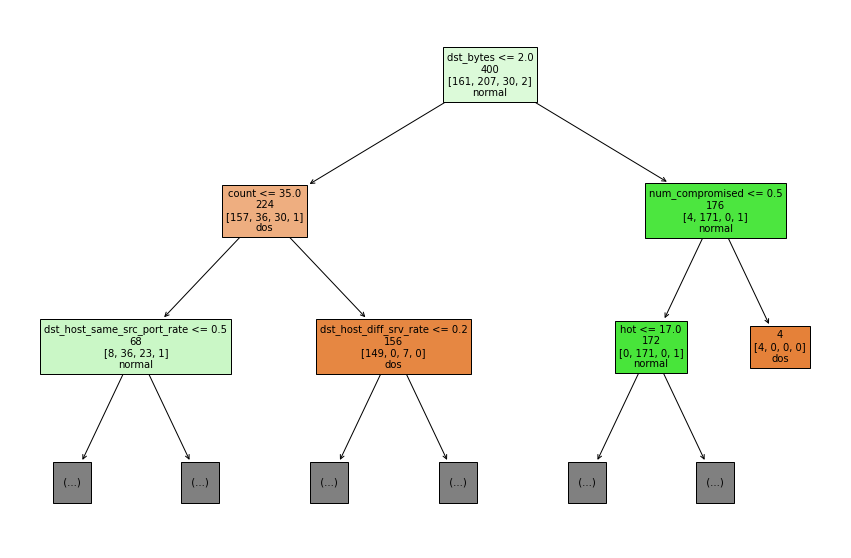

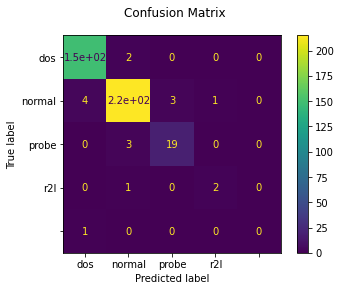

In [238]:
random_txt = make_tree(random_sample, test_sample)

### Fig 14. Decision Tree for Uniform Sample with Confusion Matrix

The test score is 0.9625


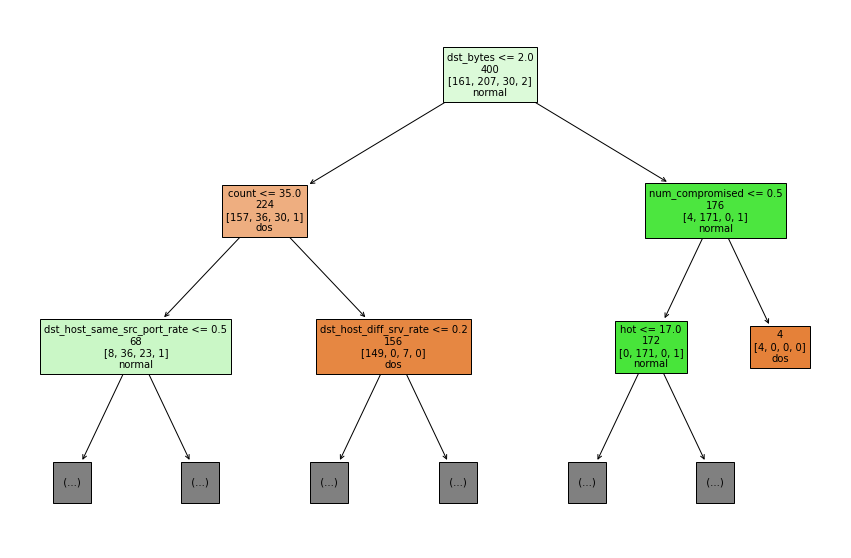

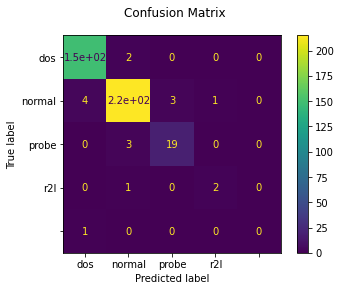

In [239]:
uni_txt = make_tree(uniform_sample, test_sample)

## Discussion

I used `difflib` to create a side-by-side comparison for the two trees, visualized in Fig 15. Note that these are not the full trees but the trees truncated to 2 nodes past root. These two trees are very much alike, identically so at this high-level. Even the scores and confusion matricies show like values. Given that the uniform distribution has greater representation of the classes U2R and R2L it stands to reason that the performance of the decision tree trained on that data set would out perform the random set. To be more specific, the random set should dispraportionately have false positives for common classes and false negatives for less common classes. 

One can be led to spleculate on how this has not occurred. Perhaps the size of the datasets was too small to give variation enough to properly learn. It is also possible that the skew of classes in the test set simply does not give enough of some classes for our model to fail. 


### Fig. 15 Side-by-side comparison of Decision Trees

In [226]:
import difflib
from IPython.core.display import display, HTML
d = difflib.HtmlDiff().make_table(random_txt.split('\n'), uni_txt.split('\n'),
                                   fromdesc='Tree1', todesc='Tree2')
HTML(d)

## References

[1] https://www.unb.ca/cic/datasets/nsl.html

[2] http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

[3] http://kdd.ics.uci.edu/databases/kddcup99/task.html

[4] https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing 

[5] https://scikit-learn.org/stable/modules/tree.html

[6] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

[7] https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html